In [13]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 805.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

How many MCQ questions on this sheet [3]: 3
How many choices per question [4]: 4

Enter the correct choice for each question (A‑D).
  Q1: b
  Q2: b
  Q3: c


⚠️  Q1 text not found – no header masking applied.

Student answers: {1: ['B'], 2: ['B'], 3: ['C']}
Final score: 3 / 3


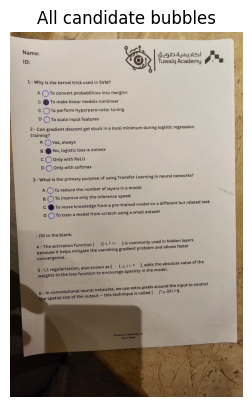

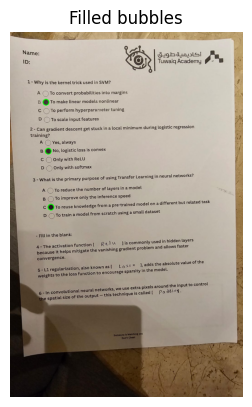

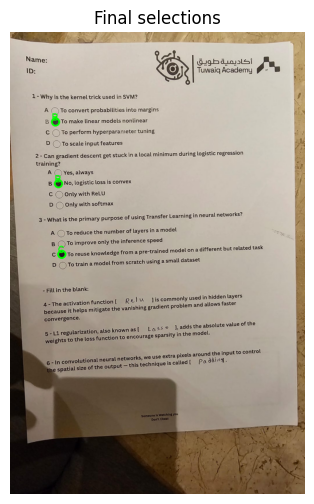

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math, string, re
import easyocr

# 1. USER‑INTERACTIVE HELPERS

def ask_int(prompt: str, default: int | None = None) -> int:
    """Prompt for a positive integer, with optional default."""
    while True:
        raw = input(f"{prompt}{' ['+str(default)+']' if default is not None else ''}: ").strip()
        if not raw and default is not None:
            return default
        if raw.isdigit() and int(raw) > 0:
            return int(raw)
        print("Please enter a positive integer.")

def get_sheet_parameters():
    """Ask for #questions, #choices, and manual answer key; return tuple."""
    num_q   = ask_int("How many MCQ questions on this sheet", 3)
    choices = ask_int("How many choices per question",        4)
    valid   = list(string.ascii_uppercase[:choices])

    answer_key = {}
    print(f"\nEnter the correct choice for each question ({valid[0]}‑{valid[-1]}).")
    for q in range(1, num_q + 1):
        while True:
            ans = input(f"  Q{q}: ").upper().strip()
            if ans in valid:
                answer_key[q] = [ans]
                break
            print(f"Use only one letter between {valid[0]} and {valid[-1]}.")
    return num_q, choices, answer_key

# 2. OCR‑BASED HEADER DETECTION
_q1_regex = re.compile(r"(^Q\s*1\b)|(^1\.)|(QUESTION\s*1)", re.I)

def find_q1_top(img_bgr: np.ndarray) -> int:
    """
    Run EasyOCR on the image and return the y‑coordinate (in pixels) of the
    *lowest* point of the bounding box that contains 'Q1' / '1.' / 'Question 1'.
    If nothing is found, return 0 so nothing is masked.
    """
    reader  = easyocr.Reader(['en'], gpu=False)
    ocr_res = reader.readtext(img_bgr, detail=1)

    for (bbox, text, conf) in ocr_res:
        if _q1_regex.search(text.strip()):
            # bbox is 4 points; take the maximum y to get the bottom of the box
            y_bottom = max(pt[1] for pt in bbox)
            print(f"📌 Found Q1 text '{text}' at y={y_bottom}px (conf={conf:.2f})")
            return y_bottom
    print("⚠️  Q1 text not found – no header masking applied.")
    return 0


# 3. IMAGE LOADING + PREPROCESS (with dynamic masking)

def load_and_preprocess(img_path: str, width: int = 800):
    """Read, resize, grayscale, threshold, then mask header above Q1."""
    original = cv2.imread(img_path)
    if original is None:
        raise FileNotFoundError(f"Image not found at {img_path}")

    resized = cv2.resize(original, (width, int(original.shape[0] * width / original.shape[1])))
    gray    = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur    = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh  = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )

    #mask everything above the Q1 line
    q1_y = find_q1_top(resized)
    if q1_y > 0:
        thresh[:q1_y, :] = 0      # kill all contours above
        gray  [:q1_y, :] = 0

    return resized, gray, thresh


# 4. BUBBLE DETECTION + GRADING

def find_candidates(thresh, area_range=(200, 5000), radius_range=(8, 15)):
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cand = []
    for c in contours:
        a = cv2.contourArea(c)
        if area_range[0] < a < area_range[1]:
            (x, y), r = cv2.minEnclosingCircle(c)
            if radius_range[0] < r < radius_range[1]:
                cand.append((int(x), int(y), int(r)))
    return cand

def filter_filled(candidates, gray, thresh, fill_ratio_min=0.5):
    filled = []
    for x, y, r in candidates:
        mask = np.zeros_like(gray)
        cv2.circle(mask, (x, y), r, 255, -1)
        filled_px = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
        ratio = filled_px / (math.pi * r * r)
        if ratio > fill_ratio_min:
            filled.append((x, y, r))
    return filled

def group_questions(filled, candidates, num_questions):
    filled.sort(key=lambda t: t[1])            # top → bottom
    filled = filled[:num_questions]            # safeguard
    groups = defaultdict(list)
    for x, y, r in candidates:
        row = min(range(len(filled)), key=lambda i: abs(filled[i][1] - y))
        groups[row].append((x, y, r))
    return filled, groups

def determine_answers(filled, groups, choices_per_q):
    answers = {}
    for qi, (fx, fy, _) in enumerate(filled, start=1):
        row = groups[qi - 1]
        unfilled_above = sum(1 for (_, y0, _) in row if y0 < fy)
        unfilled_above = min(unfilled_above, choices_per_q - 1)
        answers[qi] = [chr(ord('A') + unfilled_above)]
    return answers

def score_answers(student_answers, answer_key):
    return sum(set(student_answers[q]) == set(answer_key[q]) for q in answer_key)

# 5. VISUALISATION

def visualize(resized, candidates, filled, student_answers, answer_key):
    dbg = resized.copy()
    for x, y, r in candidates:
        cv2.circle(dbg, (x, y), r, (255, 0, 0), 1)
    plt.figure(figsize=(3, 5)); plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
    plt.title("All candidate bubbles"); plt.axis("off")

    dbg2 = resized.copy()
    for x, y, r in filled:
        cv2.circle(dbg2, (x, y), r, (0, 255, 0), 2)
    plt.figure(figsize=(3, 5)); plt.imshow(cv2.cvtColor(dbg2, cv2.COLOR_BGR2RGB))
    plt.title("Filled bubbles"); plt.axis("off")

    vis = resized.copy()
    for qi, (x, y, r) in enumerate(filled, start=1):
        correct = student_answers[qi] == answer_key[qi]
        color   = (0, 255, 0) if correct else (0, 0, 255)
        cv2.circle(vis, (x, y), r, color, 3)
        cv2.putText(vis, student_answers[qi][0], (x - r, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(4, 6)); plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Final selections"); plt.axis("off"); plt.show()

# 6. MAIN
def main():
    IMG_PATH = "/content/2cm.jpeg"   # update if needed

    num_q, choices_per_q, answer_key = get_sheet_parameters()

    resized, gray, thresh = load_and_preprocess(IMG_PATH)
    candidates = find_candidates(thresh)
    filled     = filter_filled(candidates, gray, thresh)

    if len(filled) < num_q:
        raise ValueError(f"Found only {len(filled)} filled bubbles, expected {num_q}")

    filled, groups   = group_questions(filled, candidates, num_q)
    student_answers  = determine_answers(filled, groups, choices_per_q)
    score            = score_answers(student_answers, answer_key)

    print("\nStudent answers:", student_answers)
    print(f"Final score: {score} / {num_q}")

    visualize(resized, candidates, filled, student_answers, answer_key)

if __name__ == "__main__":
    main()
